#Data Visualization for Distribution of Occluded/Non-Occluded and Image Dimension Ratio
Goal: To see if the distribution of images labeled occluded or not is significant, and if there are noticeble patterns dimensions of the images in relation to the image's primary_posture label.

In [ ]:
# Import drive
from google.colab import drive
drive.mount('/content/drive')

#Login with USC gmail

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, datasets, models
import pandas as pd
import numpy as np
import cv2

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
#from tensorflow.keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

#import files
file_list = []
file_list_simple = []
labels = pd.DataFrame()
for tranch in range(1,4):

  labels_path = '/content/drive/My Drive/M499_F20_Data/tranch' + str(tranch) + '_labels.csv'
  pictures_path = '/content/drive/My Drive/M499_F20_Data/persons-posture-tranch' + str(tranch) + '.zip'

  labels_temp = pd.read_csv(labels_path) 
  if tranch != 1:
    labels_temp['file_name'] = labels_temp.final_url
  
  labels = pd.concat([labels, labels_temp])

  zip_file = ZipFile(pictures_path)

  file_list_temp = [obj.filename for obj in zip_file.infolist()]
  file_list_simple_temp = [name.split('/')[-1] for name in file_list_temp]
  
  for path in file_list_temp:
    file_list.append(path)

  for name in file_list_simple_temp:
    file_list_simple.append(name)

In [ ]:
!pip install tf_slim

     |████████████████████████████████| 358kB 9.0MB/s 


In [ ]:
names = pd.DataFrame({'file_path': file_list, 'file_name': file_list_simple})
#size of the dataframe
df = pd.merge(names, labels, on = 'file_name')
print(len(names), len(labels), len(df))
df.file_path[0]

41182 40787 40786


'home/tyler/git/darknet/data/persons/yolo/v4/e2_0209_cat-1_002.jpg'

In [ ]:
#First drop the null values
df.drop(df[df.primary_posture.isnull()].index, axis = 0, inplace = True)
df.drop(df[df.primary_posture == 'Unknown'].index, axis = 0, inplace = True)
len(df)

36427

how_many                    One
primary_posture        Standing
primary_occluded             No
staff_patient_other       Staff
final_url                   NaN
exception_case              NaN
Name: 13970, dtype: object


(93, 68, 3)

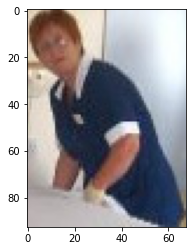

In [ ]:
#test displaying an image
im_num = np.random.randint(0, len(df))
if 'yolo' in df.iloc[im_num].file_path:
  tranch = 1
elif 'tranch2' in df.iloc[im_num].file_path:
  tranch = 2
else:
  tranch = 3

zip_file = ZipFile('/content/drive/My Drive/M499_F20_Data/persons-posture-tranch' + str(tranch) + '.zip')

im = plt.imread(zip_file.open(df.iloc[im_num].file_path))
print(df.iloc[im_num, 2:])
plt.imshow(im)
im.shape

In [ ]:
#occluded - distribution 
num_nan = len(df[df['primary_occluded'].isnull()])
num_no = len(df[df['primary_occluded'] == "No"])
num_yes = len(df[df['primary_occluded'] == "Yes"])
num_unknown = len(df[df['primary_occluded'] == "Unknown / Watermark"])
print('Number of NaN in primary occluded:', num_nan)
print('Number of No in primary occluded:', num_no)
print('Number of Yes in primary occluded:', num_yes)
print('Number of Unknown / Watermark in primary occluded:', num_unknown)
print('Total:', len(df))

Number of NaN in primary occluded: 51
Number of No in primary occluded: 22529
Number of Yes in primary occluded: 13217
Number of Unknown / Watermark in primary occluded: 630
Total: 36427


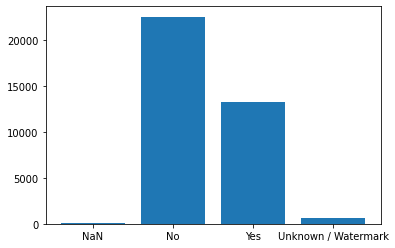

In [ ]:
count = [num_nan, num_no, num_yes, num_unknown]
primary_occluded_category = ('NaN', 'No', 'Yes', 'Unknown / Watermark')
plt.bar(primary_occluded_category, count)
plt.xticks(primary_occluded_category)
plt.show()

The number of occluded (Yes), non-occluded (No), Unknown, and NaN

In [ ]:
#split occluded/posture combinations
temp_occluded_standing = df[(df['primary_occluded'] == "Yes") & (df['primary_posture'] == "Standing")]
temp_occluded_sitting = df[(df['primary_occluded'] == "Yes") & (df['primary_posture'] == "Sitting")]
temp_occluded_lying = df[(df['primary_occluded'] == "Yes") & (df['primary_posture'] == "Lying")]
temp_occluded_no = df[df['primary_occluded'] == "No"]
temp_occluded_yes = df[df['primary_occluded'] == "Yes"]

In [ ]:
#length of occluded/posture dataframes
print(len(temp_occluded_standing))
print(len(temp_occluded_sitting))
print(len(temp_occluded_lying))
print(len(temp_occluded_no))
print(len(temp_occluded_yes))
print(len(df))

7861
3453
1903
22529
13217
36427


##Posture Distribution for Occluded/Non-Occluded

In [ ]:
#proportion of each category in primary_occluded == no
temp_occluded_no['primary_posture'].value_counts()

Standing    14029
Sitting      5707
Lying        2793
Name: primary_posture, dtype: int64

In [ ]:
#proportion of each category in primary_occluded == yes
temp_occluded_yes['primary_posture'].value_counts()

Standing    7861
Sitting     3453
Lying       1903
Name: primary_posture, dtype: int64

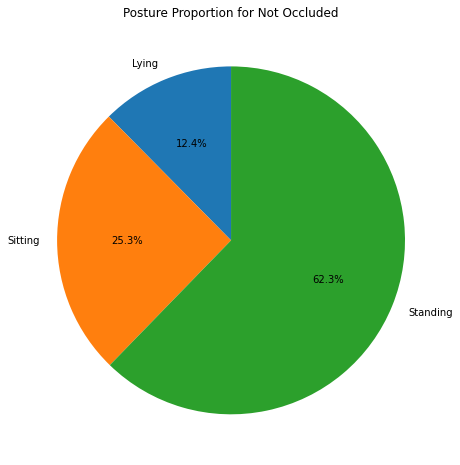

In [ ]:
#Posture Proportion for Not Occluded
label = 'Lying', 'Sitting','Standing'
plt.figure(figsize = (8,8))
plt.pie(temp_occluded_no.groupby('primary_posture').size(), labels = label, autopct='%1.1f%%', startangle=90)
plt.title('Posture Proportion for Not Occluded')
plt.show()

According to the pie chart above, the majority of non-occluded images are labeled with 'Standing', while 'Lying' is the least used label.

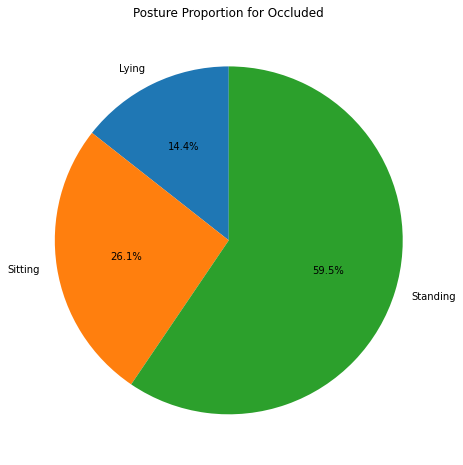

In [ ]:
#Posture Proportion for Occluded
label = 'Lying', 'Sitting','Standing'
plt.figure(figsize = (8,8))
plt.pie(temp_occluded_yes.groupby('primary_posture').size(), labels = label, autopct='%1.1f%%', startangle=90)
plt.title('Posture Proportion for Occluded')
plt.show()

Same as the non-occluded images, the majority of occluded images are labeled with 'Standing', while 'Lying' is the least used label. This is because the majority of the images in the data set are labeled with 'Standing' -- we might need a more balanced data set?

##Visualize Image Dimensions (ratio of height/width)
To see if the dimensions of the images might make a difference, when feeding the data into models.

In [ ]:
#new ratio list
df_ratio = []

In [ ]:
# height:width ratios of each of the images
for i in range(len(df)):
  if 'yolo' in df.iloc[i].file_path:
    tranch = 1
  elif 'tranch2' in df.iloc[i].file_path:
    tranch = 2
  else:
    tranch = 3

  zip_file = ZipFile('/content/drive/My Drive/M499_F20_Data/persons-posture-tranch' + str(tranch) + '.zip')
  im = plt.imread(zip_file.open(df.iloc[i].file_path))
  ratio = im.shape[0]/im.shape[1]
  df_ratio.append(ratio)


In [ ]:
#copy of original df, but add a dimension ratio column
df_with_ratio = df.copy()
df_with_ratio['ratio'] = df_ratio

In [ ]:
df_with_ratio

,file_path,file_name,how_many,primary_posture,primary_occluded,staff_patient_other,final_url,exception_case,ratio
0,home/tyler/git/darknet/data/persons/yolo/v4/e2...,e2_0209_cat-1_002.jpg,One,Sitting,No,Patient,NaN,NaN,0.590566
1,home/tyler/git/darknet/data/persons/yolo/v4/SU...,SU-O-390_cat-1_000.png,Two,Sitting,No,Patient,NaN,NaN,0.449189
2,home/tyler/git/darknet/data/persons/yolo/v4/SU...,SU-O-602_cat-1_005.jpg,One,Standing,Yes,Staff,NaN,NaN,1.438503
5,home/tyler/git/darknet/data/persons/yolo/v4/Mo...,Mohsin-O-406_cat-1_000.png,Two,Lying,No,Patient,NaN,NaN,0.818372
6,home/tyler/git/darknet/data/persons/yolo/v4/ma...,maxresdefault_cat-1_000.jpg,One,Standing,No,Staff,NaN,NaN,3.585227
...,...,...,...,...,...,...,...,...,...
40780,tranch3/cc164d7762810efb03e070e1b8c399800a6c00...,cc164d7762810efb03e070e1b8c399800a6c00027e1358...,Two,Lying,Yes,Patient,cc164d7762810efb03e070e1b8c399800a6c00027e1358...,No,0.892116
40781,tranch3/3db8fe070b0e69fbaf6d8e3e3b517379b2c3e0...,3db8fe070b0e69fbaf6d8e3e3b517379b2c3e0302e66b9...,Two,Lying,No,Patient,3db8fe070b0e69fbaf6d8e3e3b517379b2c3e0302e66b9...,No,0.315909
40783,tranch3/fa4183635bae25d0e78ffd56c7595bdb8394a2...,fa4183635bae25d0e78ffd56c7595bdb8394a2ed6e620d...,One,Standing,No,Staff,fa4183635bae25d0e78ffd56c7595bdb8394a2ed6e620d...,Yes,2.777070
40784,tranch3/630d26c03e837dbf69477d3b864b2f206ea5a9...,630d26c03e837dbf69477d3b864b2f206ea5a959212cfa...,One,Standing,Yes,Staff,630d26c03e837dbf69477d3b864b2f206ea5a959212cfa...,No,1.677249


In [ ]:
#split into different attributes for analysis

#dimension ratio for occluded, split into postures
occluded_standing = df_with_ratio[(df_with_ratio['primary_occluded'] == "Yes") & (df_with_ratio['primary_posture'] == "Standing")]
occluded_sitting = df_with_ratio[(df_with_ratio['primary_occluded'] == "Yes") & (df_with_ratio['primary_posture'] == "Sitting")]
occluded_lying = df_with_ratio[(df_with_ratio['primary_occluded'] == "Yes") & (df_with_ratio['primary_posture'] == "Lying")]

#dimension ratio for non occluded, split into postures
nonoccluded_standing = df_with_ratio[(df_with_ratio['primary_occluded'] == "No") & (df_with_ratio['primary_posture'] == "Standing")]
nonoccluded_sitting = df_with_ratio[(df_with_ratio['primary_occluded'] == "No") & (df_with_ratio['primary_posture'] == "Sitting")]
nonoccluded_lying = df_with_ratio[(df_with_ratio['primary_occluded'] == "No") & (df_with_ratio['primary_posture'] == "Lying")]

#dimension ratio for nonoccluded and occluded data
nonoccluded_all = df_with_ratio[df_with_ratio['primary_occluded'] == "No"]
occluded_all = df_with_ratio[df_with_ratio['primary_occluded'] == "Yes"]

In [ ]:
import seaborn as sns
%matplotlib inline

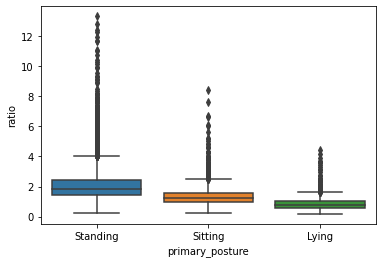

In [ ]:
sns.boxplot(y = 'ratio', x = 'primary_posture', data=nonoccluded_all).set_title('Ratio Separated by Posture (Non-Occluded)')

As we can see, typically images labeled with 'Standing' have higher height-to-width ratios than those labeled with 'Sitting' or 'Lying', and the 'Lying' images have the lowest overall height-to-width ratios. In addition, we also notice that there exist many positive outliers over the upperbound of the boxplots across all 3 posture labels.

Text(0.5, 1.0, 'Ratio Separated by Posture and Occludedness')

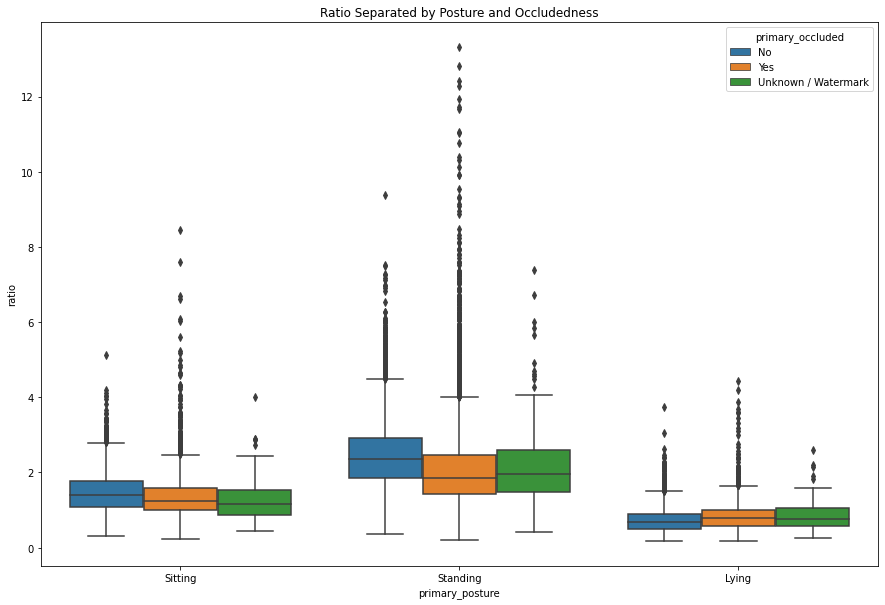

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(y = 'ratio', x = 'primary_posture', data=df_with_ratio, hue='primary_occluded').set_title('Ratio Separated by Posture and Occludedness')

When grouped by occludedness, on one hand we could still see that the 'Standing' images generally have the highest height-to-width ratios. On the other hand, for the 'Sitting' and 'Standing images those that are not occluded usually have higher height-to-width ratios than the occluded and unknown ones. Nevertheless, such a trend reversed for the 'Lying' images.

Text(0.5, 1.0, 'Ratio Separated by Posture and # of People')

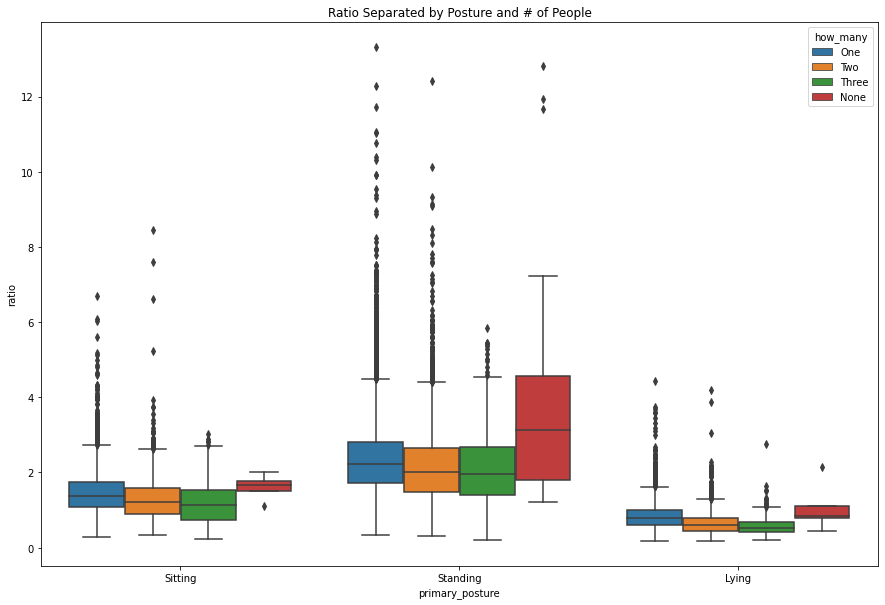

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(y = 'ratio', x = 'primary_posture', data=df_with_ratio, hue='how_many').set_title('Ratio Separated by Posture and # of People')

Grouped by the number of people (0, 1, 2, or 3) each picture contains, across all 3 posture-labels generally the larger the number of people in 1 picture, the smaller its height-to-width ratio would be (as we can see, typically the 'None' images have the largest height-to-width ratios, whereas the 'One-person' images have higher ratios than those labeled with 'Two' and 'Three', and 'Three' label is the smallest in terms of height-to-width ratios).


##Conclusion
The data is unbalanced in that the majority of the sample images are labeled with 'Standing', while the 'Lying' label is the smallest in terms of the number of pictures labeled with. Further, the majority of images labeled with 'Standing' have the highest height-to-width ratios, whereas those labeled with 'Lying' have the lowest. Additionally, although images that are not occluded seem to have higher height-to-width ratios than the occluded ones for 'Standing' and 'Sitting' labels, such a trend not longer holds for images labeled with 'Lying' probably because there are much fewer pictures labeled with 'Lying' than those labeled with 'Standing' or 'Sitting'. Furthermore, there exists a potential relationship between the number of people each image contains (from 0 to 3) and its height-to-width ratio: the more the people 1 picture contains, the lower its height-to-width ratio would be across all 3 postures labels ('Standing', 'Sitting', and 'Lying'). As a result, it might be worth splitting the data according the number of people (in each image) before preprocessing and then running them in a model.